In [1]:
import torch
import torch.nn as nn
import torchsummary
import matplotlib.pyplot as plt
import numpy as np
import random
import math


from StyleGAN import stylegan
from U_GAT_IT import ugatit_gelu

In [2]:
generator = stylegan.Generator(256, 512, 8, channel_multiplier = 2)
discriminator = stylegan.Discriminator(256, channel_multiplier = 2)

generator_ema = stylegan.Generator(256, 512, 8, channel_multiplier = 2)

generator_optim = torch.optim.Adam(generator.parameters())
discriminator_optim = torch.optim.Adam(discriminator.parameters())

In [3]:
torchsummary.summary(generator, (1, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         PixelNorm-1                  [-1, 512]               0
       EqualLinear-2                  [-1, 512]         262,656
       EqualLinear-3                  [-1, 512]         262,656
       EqualLinear-4                  [-1, 512]         262,656
       EqualLinear-5                  [-1, 512]         262,656
       EqualLinear-6                  [-1, 512]         262,656
       EqualLinear-7                  [-1, 512]         262,656
       EqualLinear-8                  [-1, 512]         262,656
       EqualLinear-9                  [-1, 512]         262,656
        PixelNorm-10                  [-1, 512]               0
      EqualLinear-11                  [-1, 512]         262,656
      EqualLinear-12                  [-1, 512]         262,656
      EqualLinear-13                  [-1, 512]         262,656
      EqualLinear-14                  [

In [4]:
torchsummary.summary(discriminator, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       EqualConv2d-1        [-1, 128, 256, 256]             384
    FusedLeakyReLU-2        [-1, 128, 256, 256]             128
       EqualConv2d-3        [-1, 128, 256, 256]         147,456
    FusedLeakyReLU-4        [-1, 128, 256, 256]             128
              Blur-5        [-1, 128, 257, 257]               0
       EqualConv2d-6        [-1, 256, 128, 128]         294,912
    FusedLeakyReLU-7        [-1, 256, 128, 128]             256
              Blur-8        [-1, 128, 255, 255]               0
       EqualConv2d-9        [-1, 256, 128, 128]          32,768
         ResBlock-10        [-1, 256, 128, 128]               0
      EqualConv2d-11        [-1, 256, 128, 128]         589,824
   FusedLeakyReLU-12        [-1, 256, 128, 128]             256
             Blur-13        [-1, 256, 129, 129]               0
      EqualConv2d-14          [-1, 512,

In [5]:
ckpt = torch.load('StyleGAN/550000.pt', map_location=torch.device('cpu'))

generator.load_state_dict(ckpt['g'])
generator_ema.load_state_dict(ckpt['g_ema'])
generator_optim.load_state_dict(ckpt['g_optim'])

discriminator.load_state_dict(ckpt['d'])
discriminator_optim.load_state_dict(ckpt['d_optim'])

In [6]:
def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises

def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


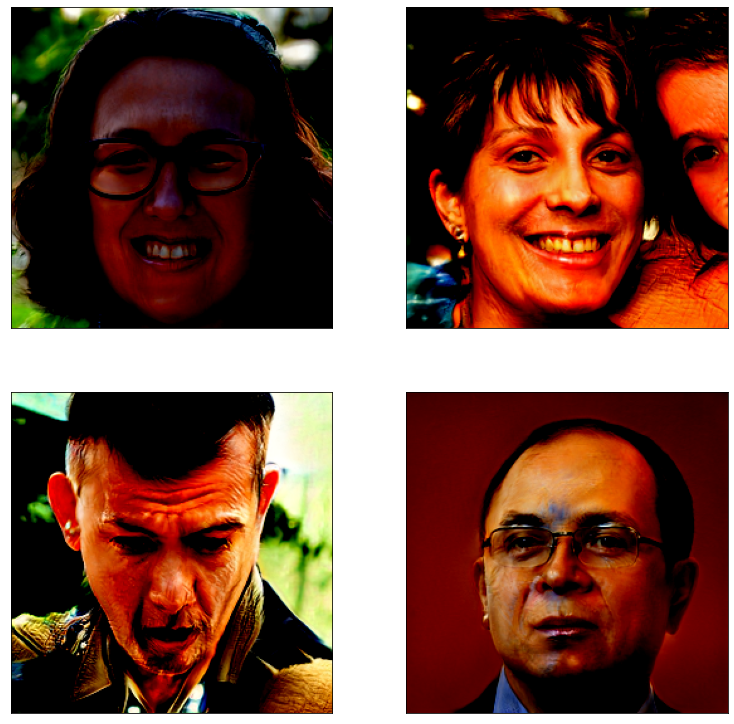

In [7]:
batch = 4
x = int(math.sqrt(batch))
noise = mixing_noise(batch, 512, 0.9, torch.device('cpu'))
fig, ax = plt.subplots(2, 2, figsize=(13, 13))

image = generator(noise)[0]
for i, img in enumerate(image.detach().numpy().transpose(0,2,3,1)):
    ax[int(i/x), i%x].imshow(img)
    ax[int(i/x), i%x].get_xaxis().set_visible(False)
    ax[int(i/x), i%x].get_yaxis().set_visible(False)
plt.show()

In [2]:
U_GAT_IT_generator = ugatit_gelu.ResnetGenerator(input_nc = 3, output_nc = 3, activation = 'gelu')

In [3]:
torchsummary.summary(U_GAT_IT_generator, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,408
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              GELU-4         [-1, 64, 256, 256]               0
   ReflectionPad2d-5         [-1, 64, 258, 258]               0
            Conv2d-6        [-1, 128, 128, 128]          73,728
    InstanceNorm2d-7        [-1, 128, 128, 128]               0
              GELU-8        [-1, 128, 128, 128]               0
   ReflectionPad2d-9        [-1, 128, 130, 130]               0
           Conv2d-10          [-1, 256, 64, 64]         294,912
   InstanceNorm2d-11          [-1, 256, 64, 64]               0
             GELU-12          [-1, 256, 64, 64]               0
  ReflectionPad2d-13          [-1, 256, 66, 66]               0
           Conv2d-14          [-1, 256,

In [2]:
U_GAT_IT_discriminator = ugatit_gelu.Discriminator(input_nc = 3)

In [3]:
torchsummary.summary(U_GAT_IT_discriminator, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 258, 258]               0
            Conv2d-2         [-1, 64, 128, 128]           3,136
              GELU-3         [-1, 64, 128, 128]               0
   ReflectionPad2d-4         [-1, 64, 130, 130]               0
            Conv2d-5          [-1, 128, 64, 64]         131,200
              GELU-6          [-1, 128, 64, 64]               0
   ReflectionPad2d-7          [-1, 128, 66, 66]               0
            Conv2d-8          [-1, 256, 32, 32]         524,544
              GELU-9          [-1, 256, 32, 32]               0
  ReflectionPad2d-10          [-1, 256, 34, 34]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
             GELU-12          [-1, 512, 31, 31]               0
           Linear-13                    [-1, 1]             512
           Linear-14                   

In [22]:
torchsummary.summary(t, (3,256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]              84
              GELU-2          [-1, 3, 128, 128]               0
Total params: 84
Trainable params: 84
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 0.75
Params size (MB): 0.00
Estimated Total Size (MB): 1.50
----------------------------------------------------------------


In [15]:
class test(nn.Module):
    def __init__(self):
        super(test, self).__init__()
        self.a = nn.Sequential(
            nn.Conv2d(3,3,3, 2, 1),
            nn.GELU(),
            
        
        )
        
    def forward(self, x):
        return self.a(x)

In [19]:
t = test()
t(torch.randn(1, 3, 256, 256)).shape

torch.Size([1, 3, 128, 128])

In [7]:
activation = 'relu'
FC = [nn.Linear(3 * 3, 3 * 3, bias=False)]
if activation == 'relu':
    FC += [nn.ReLU(True)]
FC *= 2    

In [8]:
FC

[Linear(in_features=9, out_features=9, bias=False),
 ReLU(inplace=True),
 Linear(in_features=9, out_features=9, bias=False),
 ReLU(inplace=True)]